In [1]:
import pandas as pd
from pathlib import Path
import json
from pprint import pprint
import math
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

DATA_DIR = Path("data/benchmarking")

In [2]:
def get_in_road_percentage(steps_df: pd.DataFrame) -> float:
    ret = steps_df["out_of_road"].value_counts(normalize=True).at[False]
    return ret

In [3]:
def get_n_sidewalk_crashes(steps_df: pd.DataFrame) -> int:
    """Count number of crash episodes to not count same crash multiple times"""
    try:
        # count number of times "crash" becomes True for some time
        n_crashes = steps_df["crash_sidewalk"].diff().value_counts().at[True]

        # need to divide by 2 beacouse diff counts twice
        n_crashes /= 2

        # just in case crash is last episode and we have 3.5 crash episodes make it 4
        n_crashes = math.ceil(n_crashes)
    except KeyError:
        n_crashes = 0

    return n_crashes

In [4]:
def process_steps(steps_infos: list) -> dict:
    """Accepts a list of steps and returns a dict of interesting data"""

    steps_df = pd.DataFrame(steps_infos)
    steps_data = {}
    last_step = steps_df.iloc[-1]

    steps_data = {
        "termination.arrive_dest": last_step["arrive_dest"],
        "termination.timeout": last_step["max_step"],
        "route_completion": last_step["route_completion"],
        "seed": last_step["env_seed"],
        "in_road_percentage": get_in_road_percentage(steps_df),
        "n_sidewalk_crashes": get_n_sidewalk_crashes(steps_df),
    }

    return steps_data

In [5]:
def get_scenarios_df(dir: Path):
    paths = list(dir.glob("*/*.json"))

    scenarios = []
    for file_path in tqdm(paths):

        with open(file_path, "r") as f:
            scenario_data = json.load(f)

        dir = file_path.__str__().split("/")[-2]
        _, dr, _, dt = dir.split("_")
        scenario_data["decision_repeat"] = int(dr)
        scenario_data["dt"] = float(dt)

        steps_infos = scenario_data.pop("steps_infos")
        scenario_data.update(process_steps(steps_infos))
        scenarios.append(scenario_data)
    return pd.DataFrame(scenarios)

In [6]:
df = get_scenarios_df(DATA_DIR)

100%|██████████| 1200/1200 [00:04<00:00, 279.30it/s]


In [7]:
df = df.set_index(
    [
        "dt",
        "decision_repeat",
        "seed",
    ],
    verify_integrity=True,
)

df = df.sort_index()

In [8]:
df["n_crashed_vehicles"].describe()
df["n_sidewalk_crashes"].describe()

count    1200.000000
mean        0.556667
std         1.204712
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        11.000000
Name: n_sidewalk_crashes, dtype: float64

In [9]:
# calculate driving score
# ! Problem changing the values here in the analysis can change % error

df["driving_score"] = (
    df["route_completion"]
    * df["in_road_percentage"]
    * (0.65) ** df["n_sidewalk_crashes"]
    * (0.60) ** df["n_crashed_vehicles"]
)

In [10]:
# oracle if the one of default parameters
oracle_ds = df.xs((0.02, 5))["driving_score"]
pd.set_option("display.float_format", lambda x: "%.3f" % x)
oracle_ds.describe()

count   100.000
mean      0.757
std       0.277
min       0.050
25%       0.595
50%       0.989
75%       0.991
max       0.995
Name: driving_score, dtype: float64

In [11]:
df["driving_score_error"] = (df["driving_score"] - oracle_ds).abs()
# df

In [12]:
palette = sns.color_palette("hls", 3)
x_ticks = df.index.get_level_values("decision_repeat").unique().to_list()
x_ticks

[5, 10, 15, 20]

## Original plotting


In [13]:
agg = df.select_dtypes("number").groupby(by=["dt", "decision_repeat"]).mean()
agg

start_ts  initialized_ts  scenario_done_ts  init_time  \
dt    decision_repeat                                                          
0.020 5               20054.391       20054.623         20085.696      0.232   
      10              20124.388       20124.620         20141.038      0.232   
      15              20164.188       20164.418         20177.064      0.230   
      20              20256.039       20256.271         20266.447      0.231   
0.030 5               20086.075       20086.308         20107.150      0.233   
      10              20141.402       20141.633         20153.212      0.232   
      15              20238.619       20238.849         20248.070      0.230   
      20              20266.807       20267.037         20274.271      0.231   
0.040 5               20107.518       20107.749         20123.479      0.231   
      10              20153.572       20153.800         20163.828      0.228   
      15              20248.428       20248.657         20255.682      0.229   
      20              20274.629       20274.861         20279.816      0.231   

                       scenario_time  total_time  n_crashed_vehicles  \
dt    decision_repeat                                                  
0.020 5                       31.073      31.305               0.620   
      10                      16.418      16.650               0.650   
      15                      12.646      12.877               0.850   
      20                      10.177      10.408               0.890   
0.030 5                       20.842      21.075               0.620   
      10                      11.579      11.811               0.870   
      15                       9.221       9.451               1.180   
      20                       7.234       7.465               1.210   
0.040 5                       15.730      15.961               0.730   
      10                      10.028      10.256               1.230   
      15                       7.024       7.254               1.430   
      20                       4.955       5.187               0.940   

                       max_steps  route_completion  in_road_percentage  \
dt    decision_repeat                                                    
0.020 5                 2738.680             0.967               1.000   
      10                1369.320             0.968               1.000   
      15                 912.860             0.953               1.000   
      20                 684.650             0.972               1.000   
0.030 5                 1825.790             0.974               1.000   
      10                 912.860             0.962               1.000   
      15                 608.620             0.914               0.998   
      20                 456.450             0.818               0.995   
0.040 5                 1369.320             0.972               1.000   
      10                 684.650             0.940               0.999   
      15                 456.450             0.884               0.996   
      20                 342.370             0.668               0.990   

                       n_sidewalk_crashes  driving_score  driving_score_error  
dt    decision_repeat                                                          
0.020 5                             0.050          0.757                0.000  
      10                            0.070          0.744                0.160  
      15                            0.280          0.642                0.200  
      20                            0.480          0.603                0.258  
0.030 5                             0.130          0.744                0.141  
      10                            0.350          0.635                0.241  
      15                            0.700          0.466                0.366  
      20                            0.890          0.365                0.435  
0.040 5                             0.300          0.685

### RQ1


Text(0.5, 0, 'Decision repeat')

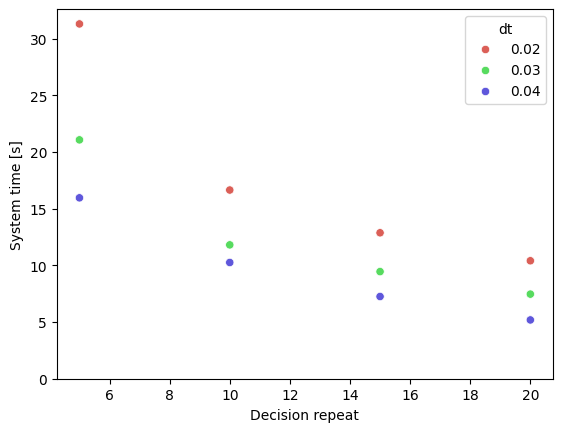

In [14]:
ax = sns.scatterplot(
    agg, x="decision_repeat", y="total_time", hue="dt", palette=palette
)
ax.set_ylim(0)
ax.set_ylabel("System time [s]")
ax.set_xlabel("Decision repeat")
# ax.set_xticks(x_ticks)

### RQ2


Text(0, 0.5, 'Driving Score Error')

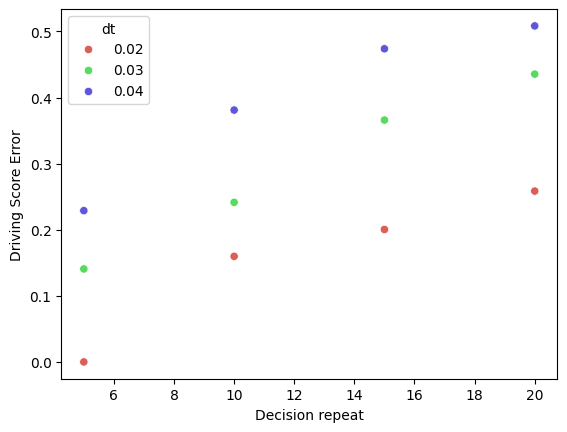

In [15]:
ax = sns.scatterplot(
    agg, x="decision_repeat", y="driving_score_error", hue="dt", palette=palette
)

ax.set_xlabel("Decision repeat")
ax.set_ylabel("Driving Score Error")

### Pareto optimality RQ1&2


Text(24.000000000000007, 0.5, 'Driving Score Error')

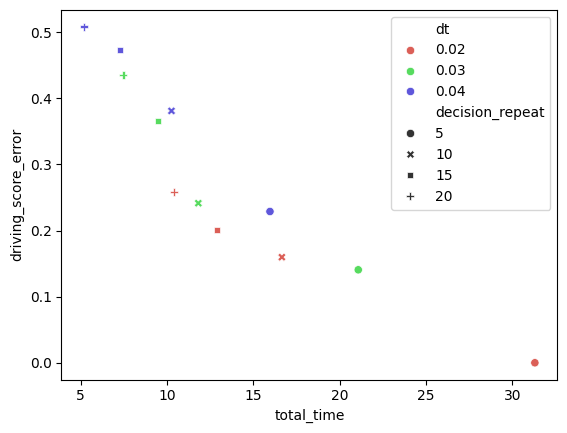

In [16]:
eax = sns.scatterplot(
    agg,
    x="total_time",
    y="driving_score_error",
    style="decision_repeat",
    hue="dt",
    palette=palette,
)

ax.set_xlabel("System time [s]")
ax.set_ylabel("Driving Score Error")